In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import os
import process_observed_discharge as mQ
import glob
import pickle
from sklearn.metrics import r2_score
import baseflow #this is the baseflow package

#segoe UI
plt.rcParams['font.family'] = 'Segoe UI'

#### Model Evaluation
Compare Q quantiles of individual models to observations

In [2]:
#Open picked flow data for evaluation stations
with open("eval_stations_Q.pickle", "rb") as f:
    eval_Obs = pickle.load(f)

#read validation stations (NSE>0
val_gdf = pd.read_csv('validation_stations_NSE_above_0.csv')

#Canals to be removed
canals = ['HACCOURT', 'Merendree_Afleidingskl Leie', 'Damme_Leopoldkl']

#Extract only stations in val_gdf
eval_Obs = {k: v for k, v in eval_Obs.items() if k in val_gdf['name'].values}


# Remove canal stations
eval_Obs = {k: v for k, v in eval_Obs.items() if k not in canals}

In [3]:
#function to match frequency and resample to desired frequency
def match_frequency_and_resample(q_model: pd.Series, q_obs: pd.Series, obs_freq: str, resample_freq: str, station_id: str):
    """
    Match frequency of model and observed discharge time series.
    Resample both to the specified frequency if they differ.
    Parameters
    ----------
    q_model : pd.Series
        Modeled discharge time series (indexed by date).
    q_obs : pd.Series
        Observed discharge time series (indexed by date).
    obs_freq : str
        The frequency of observed data (e.g., 'D' for daily).
    resample_freq : str
        Resampling frequency (e.g., 'ME' for month-end).
    station_id : str
        Identifier for the station (for logging purposes).
    Returns
    -------
    pd.Series, pd.Series
        Resampled model and observed discharge time series.
    """
    #Check if both series have the same frequency and resample if not
    #Check if both series have the same frequency and resample if not
    #set indices to datetime if not already
    if not isinstance(q_model.index, pd.DatetimeIndex):
        q_model.index = pd.to_datetime(q_model.index)
    if not isinstance(q_obs.index, pd.DatetimeIndex):
        q_obs.index = pd.to_datetime(q_obs.index)

    #Enforce daily frequency for Observed data if not already
    q_obs = q_obs.asfreq(obs_freq)   # enforce daily frequency


    if not (pd.infer_freq(q_model.index) == pd.infer_freq(q_obs.index)):
        print(f"Station {station_id}: Data will be resampled to {resample_freq}.", end="\r")

        q_model_f = q_model.resample(resample_freq).mean()

        #resample observed data only if each month has at least 15 days of data
        q_obs_f = (
            q_obs
            .resample(resample_freq)
            .apply(lambda x: x.mean() if x.count() >= 20 else np.nan)
        )

    else:
        q_model_f = q_model
        q_obs_f = q_obs

    # Align and drop NaNs
    merged_Q = pd.concat([q_model_f, q_obs_f], axis=1)
    merged_Q.columns = ["q_model", "q_obs"]
    merged_Q = merged_Q.dropna()

    return merged_Q

#==================================================

#Function to extract per station flow quantiles

def extract_flow_quantiles(merged_Q: pd.Series, station_id: str):
    """
    Extract Q50 and Q90 for model vs. observed discharge at a given station.
    Returns a single-row DataFrame or None if too short.
    Parameters
    ----------
    merged_Q : pd.Series
        DataFrame with two columns: 'q_model' and 'q_obs', indexed by date.
    station_id : str
        Identifier for the station (for logging purposes).
    Returns
    -------
    pd.DataFrame or None
        DataFrame with columns ['station', 'q50_model', 'q90_model', 'q50_obs', 'q90_obs']
        or None if insufficient overlapping data.
    """
   
    # If DataFrame, reduce to first column
    if isinstance(merged_Q, pd.DataFrame):
        q_model = merged_Q.iloc[:, 0]
        q_obs = merged_Q.iloc[:, 1]

    if len(merged_Q) > 12:  # at least 2 years of overlapping data
        print(f"Station {station_id}: {len(merged_Q)} overlapping data points found.", end="\r")
        q50_model = np.nanpercentile(q_model.values, 50)
        q90_model = np.nanpercentile(q_model.values, 10)
        q50_obs   = np.nanpercentile(q_obs.values, 50)
        q90_obs   = np.nanpercentile(q_obs.values, 10)

        return pd.DataFrame(
            {
                "station": [station_id],
                "q50_model": [q50_model],
                "q90_model": [q90_model],
                "q50_obs": [q50_obs],
                "q90_obs": [q90_obs],
            }
        )
    else:
        print(f"Station {station_id}: skipped ({len(q_model)} points only).", end="\r")
        return None

#==================================================
#change dictionary keys to upper case
def keys_upper(test_dict):
    res = dict()
    for key in test_dict.keys():
        if isinstance(test_dict[key], dict):
            res[key.upper()] = keys_upper(test_dict[key])
        else:
            res[key.upper()] = test_dict[key]
    return res

In [4]:
models = ["GFDL-ESM4", "IPSL-CM6A-LR", "MPI-ESM1-2-HR", "MRI-ESM2-0", "UKESM1-0-LL"]

all_quantiles = {}

for model in models:
    sim_files = glob.glob(f"isimip_Q/{model}/Qrouted/*.csv")
    quantiles = []  # <-- collect per model

    for fpath in sim_files:
        station_name = os.path.splitext(os.path.basename(fpath))[0]

        #match cases
        station_name = station_name.upper()

        #change dict keys to upper case
        eval_Obs_upper = keys_upper(eval_Obs)
        if station_name in eval_Obs_upper.keys():

            obs_Q = eval_Obs_upper[station_name]
            #set index to datetime if not already
            if not isinstance(obs_Q.index, pd.DatetimeIndex):
                obs_Q.index = pd.to_datetime(obs_Q.index)
            sim_Q = pd.read_csv(fpath, index_col=0, parse_dates=True)

            # Match frequency and resample to monthly
            q_merged = match_frequency_and_resample(sim_Q, obs_Q, 'D','ME', station_name)

            qn = extract_flow_quantiles(q_merged, station_name)
            if qn is not None:
                qn["model"] = model
                quantiles.append(qn)

        if quantiles:  # <-- use the correct list
            quantiles_df = pd.concat(quantiles, ignore_index=True)
        else:
            quantiles_df = pd.DataFrame()

        all_quantiles[model] = quantiles_df

#### Seasonal comparison of per-station Q

In [5]:
season_map = {12:"DJF",1:"DJF",2:"DJF",
              3:"MAM",4:"MAM",5:"MAM",
              6:"JJA",7:"JJA",8:"JJA",
              9:"SON",10:"SON",11:"SON"}

all_seasonal = {}


for model in models:
    sim_files = glob.glob(f"isimip_Q/{model}/Qrouted/*.csv")
    model_season = []

    for fpath in sim_files:
        station_name = os.path.splitext(os.path.basename(fpath))[0]

        #match cases
        station_name = station_name.upper()

        #change dict keys to upper case
        eval_Obs_upper = keys_upper(eval_Obs)

        if station_name in eval_Obs_upper.keys():

            obs_Q = eval_Obs_upper[station_name]
            sim_Q = pd.read_csv(fpath, index_col=0, parse_dates=True)

            # merge by date
            merged_df = pd.concat([sim_Q, obs_Q], axis=1, join="inner")
            merged_df.columns = ["q_model", "q_obs"]
            merged_df = merged_df.dropna()

            # add season label
            merged_df["season"] = merged_df.index.month.map(season_map)

            # seasonal climatology
            season_means = merged_df.groupby("season")[["q_model","q_obs"]].mean().reset_index()
            season_means["name"] = station_name
            season_means["model"] = model

            model_season.append(season_means)

        if model_season:
            all_seasonal[model] = pd.concat(model_season, ignore_index=True)


In [6]:
model_seasons_df = pd.concat(all_seasonal.values(), ignore_index=True)
model_seasons_df = model_seasons_df[["name", "model", "season", "q_obs", "q_model"]]

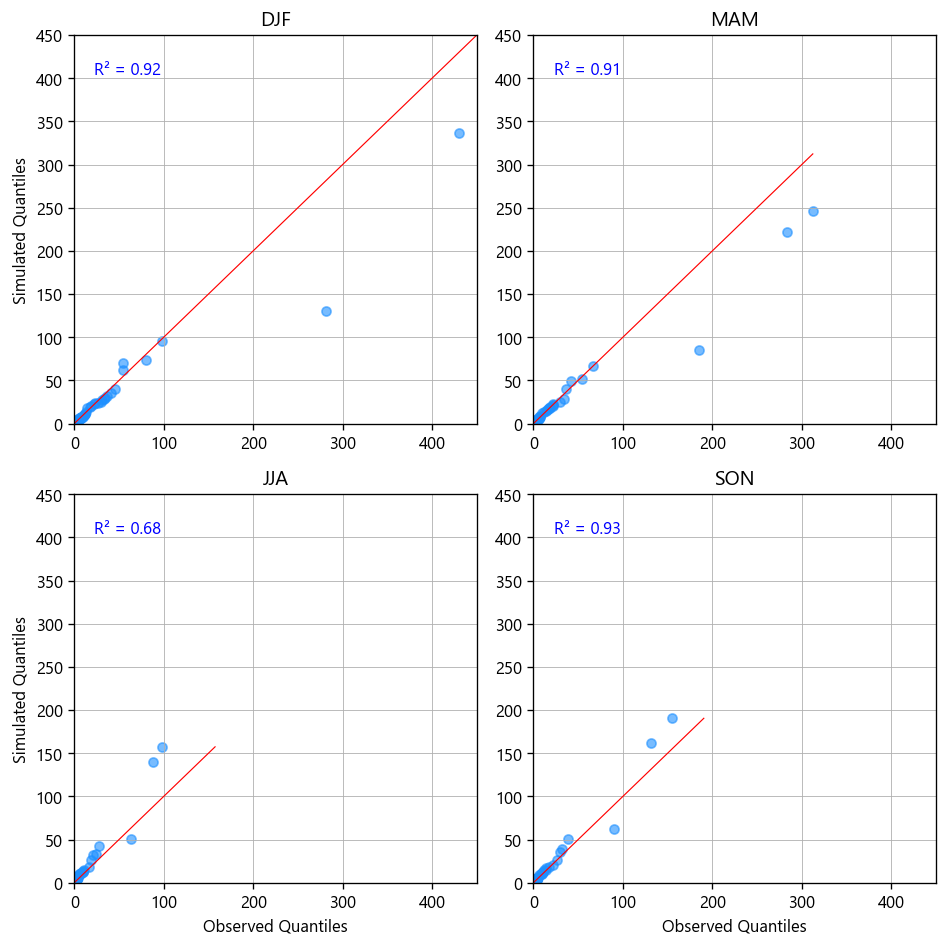

In [7]:
seasons = ["DJF", "MAM", "JJA", "SON"]
fig, axes = plt.subplots(2, 2, figsize=(8, 8), dpi=120)

for ax, season in zip(axes.ravel(), seasons):
    obs_season = model_seasons_df.loc[model_seasons_df['season'] == season, "q_obs"]
    sim_season = model_seasons_df.loc[model_seasons_df['season'] == season, 'q_model']

    # remove NaNs
    valid = obs_season.notna() & sim_season.notna()
    obs_season = obs_season[valid]
    sim_season = sim_season[valid]

    if len(obs_season) == 0:
        ax.set_title(f"{season} (no data)")
        continue

    probs = np.linspace(0, 100, 101)
    eval_Obs = np.nanpercentile(obs_season, probs)
    q_sim = np.nanpercentile(sim_season, probs)

    # Compute R²
    r2_season = r2_score(eval_Obs, q_sim)

    # Plot points
    ax.scatter(eval_Obs, q_sim, alpha=0.6, s=30, c='dodgerblue')

    # 1:1 line
    lims = [min(eval_Obs.min(), q_sim.min()), max(eval_Obs.max(), q_sim.max())]
    ax.plot(lims, lims, 'r-', lw=0.7)

    ax.set_title(season)
    ax.text(0.05, 0.9, f'R² = {r2_season:.2f}', transform=ax.transAxes, fontsize=10, color='blue')

    ax.set_xlim(0, 450)
    ax.set_ylim(0, 450)
    ax.grid(lw=0.5)

# Common x/y labels
for i, ax in enumerate(axes.ravel()):
    if i in [0, 2]:  # left column
        ax.set_ylabel("Simulated Quantiles")
    if i in [2, 3]:  # bottom row
        ax.set_xlabel("Observed Quantiles")

plt.tight_layout()
plt.show()


In [8]:
seasons = ["DJF", "MAM", "JJA", "SON"]
colors  = {"DJF":"dodgerblue", "MAM":"dodgerblue", "JJA":"dodgerblue", "SON":"dodgerblue"}

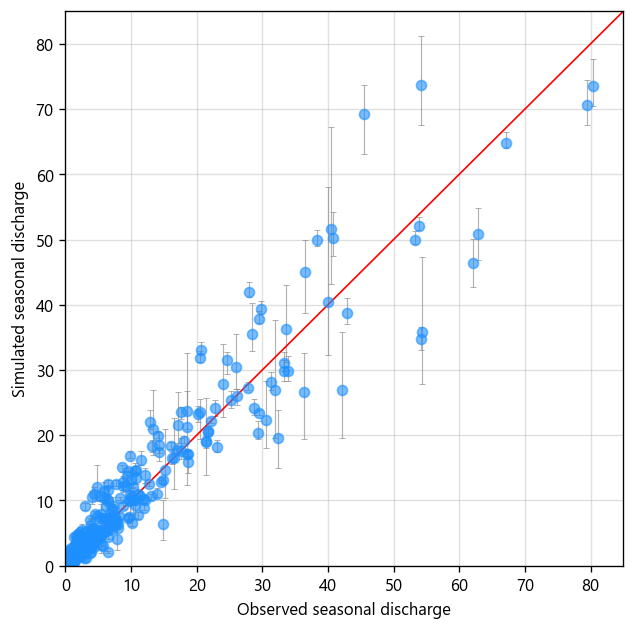

In [9]:
plt.figure(figsize=(6,6), dpi=120)
for season in seasons:
    # loop over stations
    for station in model_seasons_df['name'].unique():
        q_sim_season = model_seasons_df.loc[
            (model_seasons_df['season'] == season) &
            (model_seasons_df['name'] == station), 'q_model'
        ]
        eval_Obs_season = model_seasons_df.loc[
            (model_seasons_df['season'] == season) &
            (model_seasons_df['name'] == station), "q_obs"
        ]

        # compute ensemble stats
        mean_sim = q_sim_season.mean()
        min_sim = q_sim_season.min()
        max_sim = q_sim_season.max()
        x_obs = eval_Obs_season.mean()  # observed discharge for that station/season

        # plot with error bars
        plt.errorbar(
            x_obs, mean_sim,
            yerr=[[mean_sim - min_sim], [max_sim - mean_sim]],
            fmt='o', label=season, color=colors[season],
            alpha=0.6, capsize=2, ecolor='gray', elinewidth=0.7, capthick=0.6
            
        );

# avoid duplicate labels in legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
#plt.legend(by_label.values(), by_label.keys())
plt.xlabel("Observed seasonal discharge")
plt.ylabel("Simulated seasonal discharge")
plt.xlim(0, 85)
plt.ylim(0, 85)
plt.grid(alpha=0.4)

#1:1 line
lims = [0, 85]
plt.plot(lims, lims, 'r-', lw=1)


P-factor (percentage of points within 95PPU): 94.9%


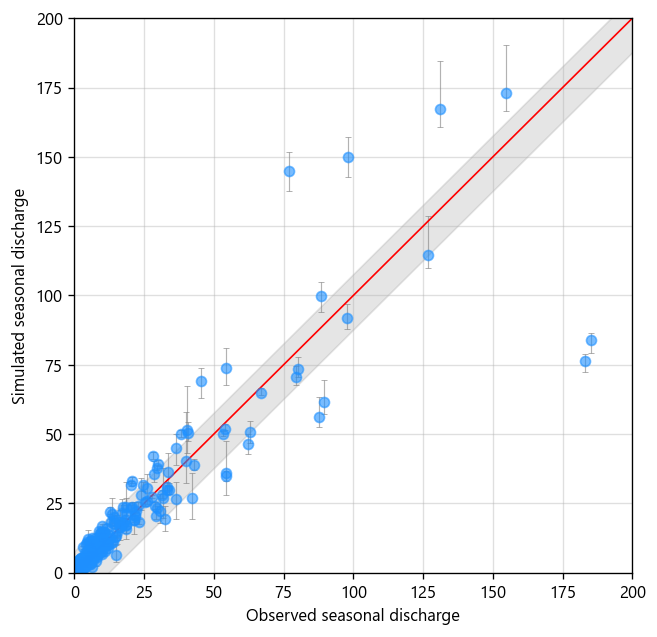

In [10]:

plt.figure(figsize=(6,6), dpi=120)

all_obs = []
all_mean_sim = []

for season in seasons:
    for station in model_seasons_df['name'].unique():
        q_sim_season = model_seasons_df.loc[
            (model_seasons_df['season'] == season) &
            (model_seasons_df['name'] == station), 'q_model'
        ]
        eval_Obs_season = model_seasons_df.loc[
            (model_seasons_df['season'] == season) &
            (model_seasons_df['name'] == station), "q_obs"
        ]

        mean_sim = q_sim_season.mean()
        min_sim = q_sim_season.min()
        max_sim = q_sim_season.max()
        x_obs = eval_Obs_season.mean()

        all_obs.append(x_obs)
        all_mean_sim.append(mean_sim)

        plt.errorbar(
            x_obs, mean_sim,
            yerr=[[mean_sim - min_sim], [max_sim - mean_sim]],
            fmt='o', label=season, color=colors[season],
            alpha=0.6, capsize=2, ecolor='gray', elinewidth=0.7, capthick=0.6
        )

# arrays
all_obs = np.array(all_obs)
all_mean_sim = np.array(all_mean_sim)

# residuals
residuals = all_mean_sim - all_obs
lower = np.percentile(residuals, 2.5)
upper = np.percentile(residuals, 97.5)

# 1:1 line
lims = [0, 200]
plt.plot(lims, lims, 'r-', lw=1)

# 95PPU band
x_line = np.linspace(lims[0], lims[1], 200)
plt.fill_between(x_line, x_line + lower, x_line + upper,
                 color='gray', alpha=0.2, label='95PPU')

# ---- Compute P-factor ----
inside = ((all_mean_sim >= all_obs + lower) & (all_mean_sim <= all_obs + upper))
p_factor = inside.mean() * 100
print(f"P-factor (percentage of points within 95PPU): {p_factor:.1f}%")

# axes, legend
plt.xlabel("Observed seasonal discharge")
plt.ylabel("Simulated seasonal discharge")
plt.xlim(lims)
plt.ylim(lims)
plt.grid(alpha=0.4)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
#plt.legend(by_label.values(), by_label.keys())

plt.show()


#### Extract Baseflow

In [ ]:
all_models_Qb = {}

for model in models:
    sim_files = glob.glob(f"isimip_Q/{model}/Qrouted/*.csv")
    stations_Qb = []  # <-- collect per model

    for fpath in sim_files:
        station_name = os.path.splitext(os.path.basename(fpath))[0]

        #match cases
        station_name = station_name.upper()

        if station_name not in eval_Obs_upper:
            continue  # skip stations without obs
        if station_name in canals:
            continue  # skip canal stations

        obs_Q = eval_Obs_upper[station_name]
        #set index to datetime if not already
        if not isinstance(obs_Q.index, pd.DatetimeIndex):
            obs_Q.index = pd.to_datetime(obs_Q.index)
        sim_Q = pd.read_csv(fpath, index_col=0, parse_dates=True)

        q_merged = match_frequency_and_resample(sim_Q, obs_Q, 'D','D', station_name)

        if q_merged.empty:
            print(f"Station {station_name}: No overlapping data after resampling.", end="\r")
            continue

        #extract baseflow
        obs_bf_dict, obs_bfi, obs_kge = baseflow.separation(q_merged[["q_obs"]], return_bfi=True, return_kge=True)

        #select the best method based on KGE
        best_method = obs_kge.idxmax(axis=1).iloc[0]  #iloc[0] grabs the station name from the index

        #extract the baseflow timeseries for the best method
        obs_Qb = obs_bf_dict[best_method]

        #use the same best method to extract the baseflow from the simulated Q
        sim_bf_dict, sim_bfi, sim_df_kge = baseflow.separation(q_merged[['q_model']], return_bfi=True, return_kge=True, method=best_method)
        sim_Qb= sim_bf_dict[best_method]

        #concatenate the results
        station_Qb = pd.concat([obs_Qb, sim_Qb], axis=1)
        station_Qb['station'] = station_name
        station_Qb.columns = ['obs_Qb', 'sim_Qb', 'station']
        stations_Qb.append(station_Qb)
    
    if stations_Qb:  # <-- use the correct list
        model_Qb_df = pd.concat(stations_Qb)
        model_Qb_df['model'] = model
        all_models_Qb[model] = model_Qb_df

In [25]:
seasonal_baseflow = []

# Initialize a dictionary to hold seasonal data for the station
for model in models:
    model_df = all_models_Qb[model]

    stations_Qb = []  # <-- collect per model

    for nameStation in model_df['station'].unique():

        station_df = model_df[model_df['station'] == nameStation]
        
        station_df = station_df.copy()
        station_df["season"] = station_df.index.month.map(season_map)

        # seasonal climatology
        season_Qb = station_df.groupby("season")[["obs_Qb","sim_Qb"]].mean().reset_index()
        season_Qb["name"] = nameStation
        season_Qb["model"] = model
        stations_Qb.append(season_Qb)
    
    if stations_Qb:  # <-- use the correct list
        model_Qb_df = pd.concat(stations_Qb)
        seasonal_baseflow.append(model_Qb_df)
    
    #convert to dataframe
seasonal_baseflow_df = pd.concat(seasonal_baseflow)
#rearrange columns
seasonal_baseflow_df = seasonal_baseflow_df[["name", "model", "season", "obs_Qb", "sim_Qb"]]


In [39]:
def plot_multimodel_spread(flow_df: dict, seasons: dict,
                           obs_name: str, sim_name: str,
                           xlabel: str ,
                           ylabel: str ):
    
    """ 
    Plot the spread of simulated vs observed baseflow for multiple models with 95PPU
    and compute the P-factor.
    Parameters
    ----------
    flow_df : dict
        dataframe with flow for different models with columns: 'name', 'season', obs_name, sim_name, model for each model
    seasons : list
        List of seasons to consider (e.g., ["DJF", "MAM", "JJA", "SON"]) mapped to month numbers
    obs_name : str
        Name of the observed flow column
    sim_name : str
        Name of the simulated flow column

    Returns
    -------
    plots the scatter plot with error bars and 95PPU band
    and prints the P-factor
    """
    plt.figure(figsize=(8,6), dpi=120)

    all_obs = []
    all_mean_sim = []
    for season in seasons:
        for station in flow_df['name'].unique():
            q_sim_season = flow_df.loc[
                (flow_df['season'] == season) &
                (flow_df['name'] == station), sim_name]
            
            eval_Obs_season = flow_df.loc[
                (flow_df['season'] == season) &
                (flow_df['name'] == station), obs_name]

            mean_sim = q_sim_season.mean()
            min_sim = q_sim_season.min()
            max_sim = q_sim_season.max()
            x_obs = eval_Obs_season.mean()

            all_obs.append(x_obs)
            all_mean_sim.append(mean_sim)

            plt.errorbar(
                x_obs, mean_sim,
                yerr=[[mean_sim - min_sim], [max_sim - mean_sim]],
                fmt='o', label=season, color=colors[season],
                alpha=0.6, capsize=2, ecolor='gray', elinewidth=0.7, capthick=0.6
            )
    # arrays
    all_obs = np.array(all_obs)
    all_mean_sim = np.array(all_mean_sim)

    # residuals
    residuals = all_mean_sim - all_obs
    lower = np.percentile(residuals, 2.5)
    upper = np.percentile(residuals, 97.5)

    # 1:1 line
    lims = [0, 60]
    plt.plot(lims, lims, 'r-', lw=1)

    # 95PPU band
    x_line = np.linspace(lims[0], lims[1], 200)
    plt.fill_between(x_line, x_line + lower, x_line + upper,
                    color='gray', alpha=0.2, label='95PPU')

    # ---- Compute P-factor ----
    inside = ((all_mean_sim >= all_obs + lower) & (all_mean_sim <= all_obs + upper))
    p_factor = inside.mean() * 100
    print(f"P-factor (percentage of points within 95PPU): {p_factor:.1f}%")

    # axes, legend
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xlim(lims)
    plt.ylim(lims)
    plt.grid(alpha=0.4)

    #handles, labels = plt.gca().get_legend_handles_labels()
    #by_label = dict(zip(labels, handles))
    #plt.legend(by_label.values(), by_label.keys())

    plt.show()

P-factor (percentage of points within 95PPU): 94.9%


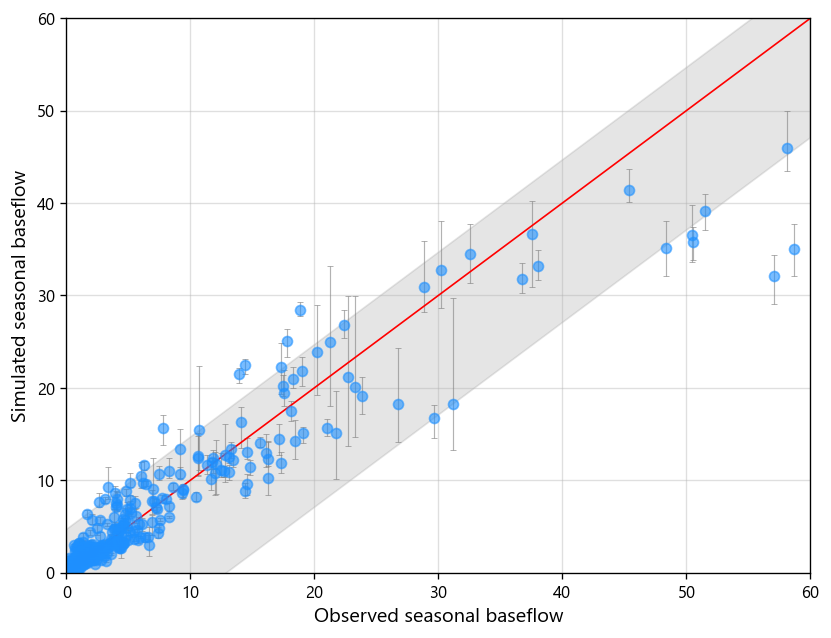

In [40]:
plot_multimodel_spread(seasonal_baseflow_df, seasons,
                       'obs_Qb', 'sim_Qb',
                       xlabel="Observed seasonal baseflow",
                       ylabel="Simulated seasonal baseflow")

P-factor (percentage of points within 95PPU): 94.9%


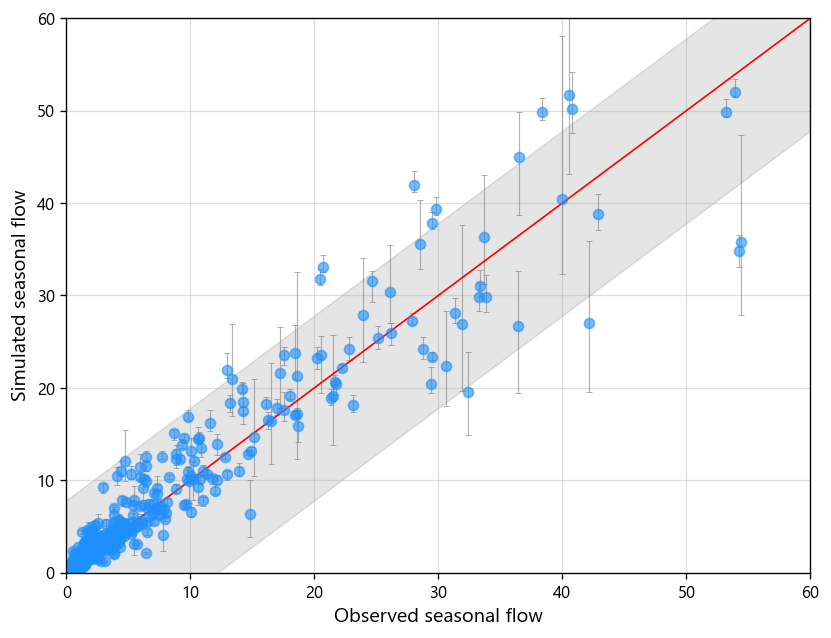

In [41]:
plot_multimodel_spread(model_seasons_df, seasons,
                       "q_obs", 'q_model',
                       xlabel="Observed seasonal flow",
                       ylabel="Simulated seasonal flow")

In [43]:
model_seasons_df[model_seasons_df['name']=='YVOIR']

,name,model,season,q_obs,q_model
664,YVOIR,GFDL-ESM4,DJF,3.092482,4.203393
665,YVOIR,GFDL-ESM4,JJA,1.676196,1.758883
666,YVOIR,GFDL-ESM4,MAM,2.652635,2.906223
667,YVOIR,GFDL-ESM4,SON,1.500556,2.113682
1336,YVOIR,IPSL-CM6A-LR,DJF,3.092482,4.222392
1337,YVOIR,IPSL-CM6A-LR,JJA,1.676196,1.756503
1338,YVOIR,IPSL-CM6A-LR,MAM,2.652635,2.779114
1339,YVOIR,IPSL-CM6A-LR,SON,1.500556,2.121286
2008,YVOIR,MPI-ESM1-2-HR,DJF,3.092482,4.051696
2009,YVOIR,MPI-ESM1-2-HR,JJA,1.676196,1.747333
